# Imports

In [10]:
import os
import pyproj
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point
from IPython.display import clear_output
%matplotlib inline

# Load Data
### Census Tract

In [145]:
ct = gp.read_file("../data/external/nyct2010_17b/nyct2010.shp")
ct = ct[ct.BoroName == "Manhattan"]
ct.head(2)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
1,1009800,1,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507019043 214848.8975830078, ..."
2,1010000,1,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861328 216013.1307983398,..."


### MapPLUTO

In [12]:
mn = gp.read_file("../data/external/mappluto/MN/MNMapPLUTO.shp")
mn_ct_file = "../data/results/mn_ct.npy"

if not os.path.isfile(mn_ct_file):
    mn_x, mn_y = np.array([(i.x, i.y) for i in mn.centroid]).T
    mn_ct = []
    nmn = len(mn_x)
    
    for ii in range(nmn):
        if (ii + 1) % 100 == 0:
            print ("{0} of {1}".format(ii + 1, nmn))
            clear_output(wait=True)
            
        pnt  = Point(mn_x[ii], mn_y[ii])
        cont = ct[ct.contains(pnt)]
        
        if len(cont) == 1:
            mn_ct.append(cont.iloc[0].BoroCT2010)
        elif len(cont) == 0:
            mn_ct.append(0)
            print("Census Tract not found for {0}!!!".format(mn.iloc[ii].BBL))
            clear_output(wait=True)
        else:
            mn_ct.append(0)
            print("{0} Census Tracts found for {1}!!!".format(len(cont), mn.iloc[ii].BBL))
            clear_output(wait=True)
            
    np.save(mn_ct_file, np.array(mn_ct))

else:
    mn_ct = np.load(mn_ct_file)

mn["BoroCT2010"] = mn_ct
mn.head(2)

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry,BoroCT2010
0,0.000000e+00,None,1 ELLIS ISLAND,2,14972400.0,108450450.0,1.000010e+09,603130,Z9,0.0,...,1900,None,10004,R3-2,None,None,None,12b,"POLYGON ((973154.7117999941 194614.3315999955,...",0
1,1.000090e+09,12/26/1985,17 STATE STREET,2,14670000.0,59250600.0,1.000090e+09,544015,O4,118.0,...,1987,None,10004,C5-5,None,None,None,12b,"POLYGON ((980492.3622000068 195423.9451999962,...",1000900


### Precipitation 

In [13]:
prcp = pd.read_csv("../data/external/nyc_centralpark_2017precip.csv",
                   usecols=["DATE", "PRCP"], parse_dates=["DATE"])
prcp["d"] = prcp.DATE.dt.strftime("%Y-%m-%d")
low_rain = prcp[prcp.PRCP < 0.05]
low_rain.sort_values("DATE", ascending=False).head(2)

,DATE,PRCP,d
247,2017-09-05,0.0,2017-09-05
246,2017-09-04,0.0,2017-09-04


### Cameras

In [14]:
cams = pd.read_csv("../data/external/cameras.csv")
proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
cams["lat_nys"], cams["lon_nys"] = zip(*[proj(i, j) for i, j in zip(cams.long, cams.lat)])

mn_cams = cams[(cams.boro == "Manhattan") & (cams.people == 1.)].copy()

cam_ct = []

for ii in range(len(mn_cams)):
    pnt = Point(mn_cams.iloc[ii].lat_nys, mn_cams.iloc[ii].lon_nys)
    cont = ct[ct.contains(pnt)]
    
    if len(cont) == 1:
        cam_ct.append(cont.iloc[0].BoroCT2010)
    elif len(cont) == 0:
        cam_ct.append(0)
        print("Census Tract not found for {0}!!!".format(mn_cams.iloc[ii].cam_id))
        clear_output(wait=True)
    else:
        cam_ct.append(0)
        print("{0} Census Tracts found for {1}!!!" \
                  .format(cont.sum(), mn_cams.iloc[ii].cam_id))
        clear_output(wait=True)

mn_cams["BoroCT2010"] = cam_ct
mn_cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode,lat_nys,lon_nys,BoroCT2010
4,172,11,Baxter St @ Canal Street,40.716623,-73.999186,1.0,1.0,Manhattan,10013,984475.771706,200361.648135,1002900
9,421,438,Broadway @ 51 St,40.761268,-73.983564,1.0,1.0,Manhattan,10019,988803.094969,216627.749248,1013100


### Hadive

In [94]:
hdv = pd.read_feather("../data/results/hadive-data.feather").set_index("date")
mn_wd_hdv = hdv[(hdv.cam_id.isin(mn_cams.cam_id.unique())) & 
                (hdv.index.weekday < 5)].copy()
dt_values = [(t[:10], t[11:16]) for t in (mn_wd_hdv.index.round("5Min").values).astype(str)]
mn_wd_hdv["d"] = [x[0] for x in dt_values]
mn_wd_hdv["t"] = [x[1] for x in dt_values]
mn_wd_hdv = mn_wd_hdv[mn_wd_hdv.d.isin(low_rain.d.unique())]
mn_wd_hdv.head(2)

,cam_id,count,d,t
date,,,,
2017-06-27 23:57:33,988,0,2017-06-28,00:00
2017-06-27 23:57:33,166,0,2017-06-28,00:00


# Analysis
### Calculate residential and commercial area for each census tract.

In [146]:
mn_sum = mn.groupby("BoroCT2010").sum().reset_index()
ct = ct.merge(mn_cams.groupby("BoroCT2010").size().reset_index().rename(columns={0: "NumCams"}), how="left", on="BoroCT2010").fillna(0.) \
       .merge(mn_sum[["BoroCT2010", "ResArea", "ComArea", "BldgArea"]], how="left", on="BoroCT2010")
res_area = ct.ResArea.astype(float)
com_area = ct.ComArea.astype(float)
tot_area = ct.BldgArea.astype(float)
    
ct["AreaRat"] = res_area / ((res_area + com_area) + ((res_area + com_area) == 0))
ct["ResFrac"] = res_area / tot_area
ct["ComFrac"] = com_area / tot_area

### Calculate the average time series for each camera

In [147]:
wd = mn_wd_hdv.groupby(["cam_id", "t"]).mean().unstack(level=1)
wd.columns = [pd.to_datetime("9-9-99 " + t) for t in wd.columns.droplevel()]
wd_norm = ((wd.T - wd.T.mean()) / wd.T.std()).T.sort_index()
wd_vals = wd_norm.values

In [148]:
mn_cams_ct = mn_cams[["cam_id", "BoroCT2010"]].merge(
                ct[["BoroCT2010", "ResArea", "ComArea", "BldgArea",
                    "AreaRat", "ResFrac", "ComFrac"]], 
                on="BoroCT2010", how="left").set_index("cam_id").sort_index()

mn_cams_ct.head(2)

,BoroCT2010,ResArea,ComArea,BldgArea,AreaRat,ResFrac,ComFrac
cam_id,,,,,,,
163,1001300,3401872,20257104,24919762,0.143788,0.136513,0.812893
165,1007800,5119180,1850176,6969356,0.734527,0.734527,0.265473


### Fit Model

In [149]:
rind = mn_cams_ct["AreaRat"].argsort()
wd_valsr = wd_vals[rind]

In [150]:
def gauss(xx, xx0, sig):
    return np.exp(-(xx - xx0)**2 / (2.0 * sig**2))

xx   = np.arange(float(wd_valsr.shape[1]))
wgt  = np.array([1.1, 1.8, 1.9, -1.0])
tmpl = np.array([gauss(xx, 102., 10.), gauss(xx, 155., 40.),
                 gauss(xx, 222., 19.), np.ones(xx.size)])

wgts = np.zeros((wd_valsr.shape[0], 4))

for ii in range(wd_valsr.shape[0]):
    wgts[ii] = np.dot(np.linalg.inv(np.dot(tmpl, tmpl.T)),
                      np.dot(tmpl, wd_valsr[ii]))

mod = np.dot(wgts, tmpl)

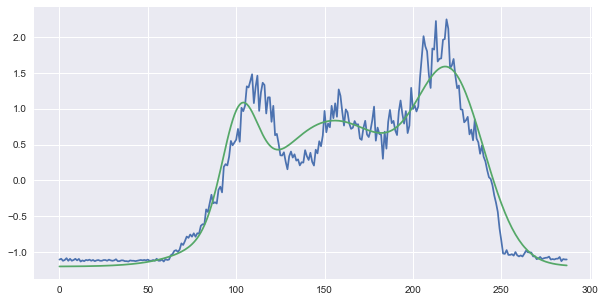

In [151]:
ii = 120
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(xx, wd_valsr[ii])
ax.plot(xx, mod[ii])

[]

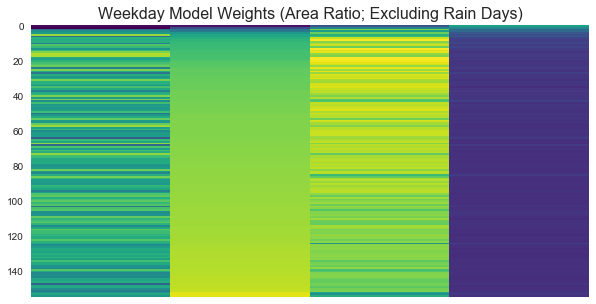

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.imshow(wgts[wgts[:, 1].argsort()], aspect="auto", cmap="viridis")
ax.grid(False)
ax.set_title("Weekday Model Weights (Area Ratio; Excluding Rain Days)", fontsize=16)
ax.set_xticks([])

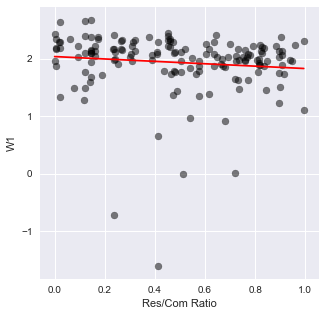

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
m, b = np.polyfit(mn_cams_ct.sort_values("AreaRat").AreaRat.values, wgts[:, 1], 1)
ax.scatter(mn_cams_ct.sort_values("AreaRat").AreaRat, wgts[:, 1], c="k", alpha=0.5)
ax.plot(mn_cams_ct.sort_values("AreaRat").AreaRat, 
        m*mn_cams_ct.sort_values("AreaRat").AreaRat+b, c="r")
ax.set_ylabel("W1")
ax.set_xlabel("Res/Com Ratio")